## Parsing of Data using Various files

In [2]:
import pandas as pd

# Paths to your ASCII files
position_file_path= "/home/s186/Downloads/ML_For_Model Training/ML_For_Model Training/training_data/BESTPOS.ASCII"
inspvax_file_path = "/home/s186/Downloads/ML_For_Model Training/ML_For_Model Training/training_data/INSPVAX.ASCII"
coreimu_file_path = "/home/s186/Downloads/ML_For_Model Training/ML_For_Model Training/training_data/CORRIMUDATA.ASCII"
bestvel_file_path = "/home/s186/Downloads/ML_For_Model Training/ML_For_Model Training/training_data/BESTVEL.ASCII"
def parse_position_data(file_path):
    data = []
    ref_time=None
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#BESTPOSA'):
                parts = line.split(';')
                time_data, pos_data = parts[0].split(','), parts[1].split(',')
                # Parse time data
                _, pos_data = parts[0], parts[1].split(',')
                lat = float(pos_data[2])
                lon = float(pos_data[3])
                data.append((lat, lon))
    return pd.DataFrame(data, columns=['Latitude', 'Longitude'],dtype='float')

def parse_inspvax_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#INSPVAX'):
                parts = line.split(';')
                time_data,ins_data = parts[0].split(','), parts[1].split(',')
                roll = float(ins_data[9])
                pitch = float(ins_data[10])
                azimuth = float(ins_data[11])
                data.append((roll, pitch, azimuth))
    return pd.DataFrame(data, columns=['Roll', 'Pitch', 'Azimuth'])

def parse_coreimu_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#CORRIMUDATA'):
                time_data, fields = line.split(';')
                time_data = time_data.split(',')
                fields = fields.split(',')
                acc_x = float(fields[5])
                acc_y = float(fields[6])
                acc_z = float(fields[7].split('*')[0])
                data.append((acc_x, acc_y, acc_z))
    return pd.DataFrame(data, columns=['Acc_x', 'Acc_y', 'Acc_z'])

def parse_bestvel_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#BESTVELA'):
                time_data, fields = line.split(';')
                time_data = time_data.split(',')
                fields = fields.split(',')
                hor_speed = float(fields[4])
                trk_ground = float(fields[5])
                data.append((hor_speed, trk_ground))
    return pd.DataFrame(data,columns=['Hor_speed','Trk_ground'])

# Parse data from each file
gnss_df = parse_position_data(position_file_path)
ins_df = parse_inspvax_data(inspvax_file_path)
acc_df = parse_coreimu_data(coreimu_file_path)
bestvel_df = parse_bestvel_data(bestvel_file_path)
pd.set_option('display.precision', 12)
print(len(gnss_df),len(ins_df),len(acc_df),len(bestvel_df))
# Check lengths and merge dataframes
if len(gnss_df) == len(ins_df) == len(acc_df)==len(bestvel_df):
    final_df = pd.concat([gnss_df, ins_df, acc_df,bestvel_df], axis=1)
    final_df['Delta_Latitude'] = final_df['Latitude'].diff()
    final_df['Delta_Longitude'] = final_df['Longitude'].diff()
    final_df = final_df.dropna().reset_index(drop=True)  # Drop the first row with NaN differences and reset index
else:
    print("Data mismatch in length",len(gnss_df),len(ins_df),len(acc_df),len(bestvel_df))

print(final_df.head())

72019 72019 72019 72019
         Latitude       Longitude         Roll        Pitch        Azimuth  \
0  17.60120055273  78.12661595350 -0.097655428 -1.986128161  167.600802209   
1  17.60120055409  78.12661595601 -0.097635916 -1.988084200  167.600704678   
2  17.60120055971  78.12661595665 -0.096705519 -1.986534633  167.598441245   
3  17.60120055496  78.12661596423 -0.095110718 -1.987779445  167.597669030   
4  17.60120055341  78.12661596567 -0.098366652 -1.982730367  167.597312689   

            Acc_x           Acc_y           Acc_z  Hor_speed  Trk_ground  \
0  0.000668961179 -0.000683828111  0.000870046058     0.0150  107.771624   
1 -0.001015695051 -0.000567978411  0.000713849990     0.0146   27.387554   
2  0.000962881395  0.000532521510  0.001059954995     0.0169   79.936083   
3 -0.000527240694 -0.000060492200 -0.000142496249     0.0172   45.513679   
4 -0.000348133881  0.000133973907  0.001799201166     0.0046  138.273849   

   Delta_Latitude  Delta_Longitude  
0   0.0000000

## LSTM Model

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib


# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth', 'Acc_x', 'Acc_y', 'Acc_z', 'Hor_speed', 'Trk_ground']
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Define sequence length
seq_length = 5  # Adjust based on your data

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences for LSTM
X_lat_seq, y_lat_seq = create_sequences(X_scaled, y_lat.values, seq_length)
X_lon_seq, y_lon_seq = create_sequences(X_scaled, y_lon.values, seq_length)

# Split into train and test sets
train_size = int(len(X_lat_seq) * 0.8)
X_lat_train, X_lat_test = X_lat_seq[:train_size], X_lat_seq[train_size:]
y_lat_train, y_lat_test = y_lat_seq[:train_size], y_lat_seq[train_size:]

X_lon_train, X_lon_test = X_lon_seq[:train_size], X_lon_seq[train_size:]
y_lon_train, y_lon_test = y_lon_seq[:train_size], y_lon_seq[train_size:]

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Latitude model
model_lat = build_lstm_model((seq_length, len(features)))
model_lat.fit(X_lat_train, y_lat_train, epochs=50, batch_size=32, validation_split=0.2)

# Longitude model
model_lon = build_lstm_model((seq_length, len(features)))
model_lon.fit(X_lon_train, y_lon_train, epochs=50, batch_size=32, validation_split=0.2)

# Save trained models to files
model_lat.save('nlstm_lat_model.h5')
model_lon.save('nlstm_lon_model.h5')


2024-06-03 16:22:48.989593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
1441/1441 [==============================] - 8s 4ms/step - loss: 1.1647e-04 - val_loss: 1.1811e-06
Epoch 2/50
1441/1441 [==============================] - 6s 4ms/step - loss: 6.5757e-06 - val_loss: 1.1131e-07
Epoch 3/50
1441/1441 [==============================] - 6s 4ms/step - loss: 2.0067e-06 - val_loss: 2.5237e-08
Epoch 4/50
1441/1441 [==============================] - 6s 4ms/step - loss: 6.9815e-07 - val_loss: 1.3632e-08
Epoch 5/50
1441/1441 [==============================] - 6s 4ms/step - loss: 2.4785e-07 - val_loss: 2.1379e-09
Epoch 6/50
1441/1441 [==============================] - 6s 4ms/step - loss: 8.2855e-08 - val_loss: 4.9081e-08
Epoch 7/50
1441/1441 [==============================] - 6s 4ms/step - loss: 2.6024e-08 - val_loss: 6.6948e-10
Epoch 8/50
1441/1441 [==============================] - 6s 4ms/step - loss: 7.1535e-09 - val_loss: 3.1784e-09
Epoch 9/50
1441/1441 [==============================] - 6s 4ms/step - loss: 2.0464e-09 - val_loss: 2.1304e-11
Epoch 10/5

/home/s186/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


451/451 [==============================] - 1s 1ms/step
Latitude Prediction R^2 Score: -132.888989190401531
Longitude Prediction R^2 Score: -136.445196602716550
Mean Squared Error (MSE) for Delta_Latitude: 0.00000000075537252
Mean Squared Error (MSE) for Delta_Longitude: 0.00000000104863098


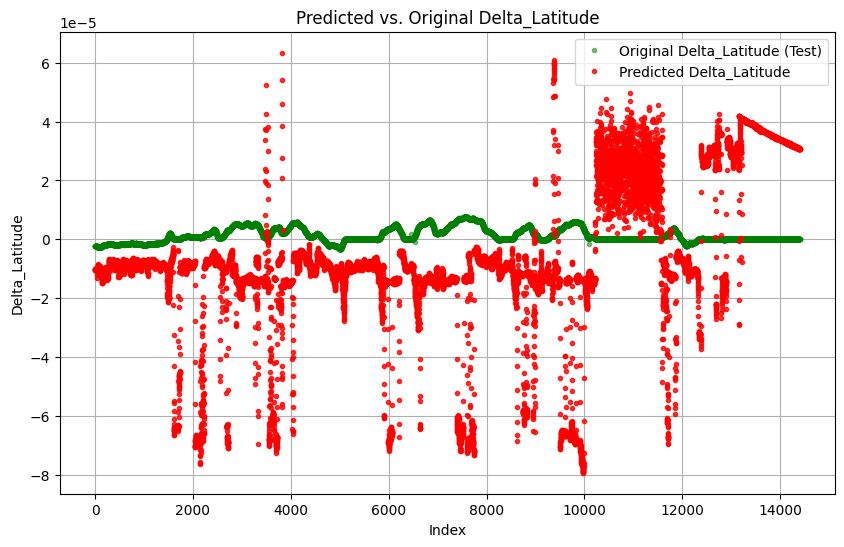

In [6]:
from matplotlib import pyplot as plt
# Make predictions
y_lat_pred = model_lat.predict(X_lat_test)
y_lon_pred = model_lon.predict(X_lon_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.15f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.15f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude and Delta_Longitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.17f}")

lon_mse = mean_squared_error(y_lon_test, y_lon_pred)
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.17f}")

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(range(len(y_lat_test)), y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(range(len(y_lat_test)), y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('Predicted vs. Original Delta_Latitude')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()


## Random Forest

Latitude Prediction R^2 Score: 0.999595094696116
Longitude Prediction R^2 Score: 0.999704402656935
Mean Squared Error (MSE) for Delta_Latitude: 0.00000000000000423
Mean Squared Error (MSE) for Delta_Longitude: 0.00000000000000429


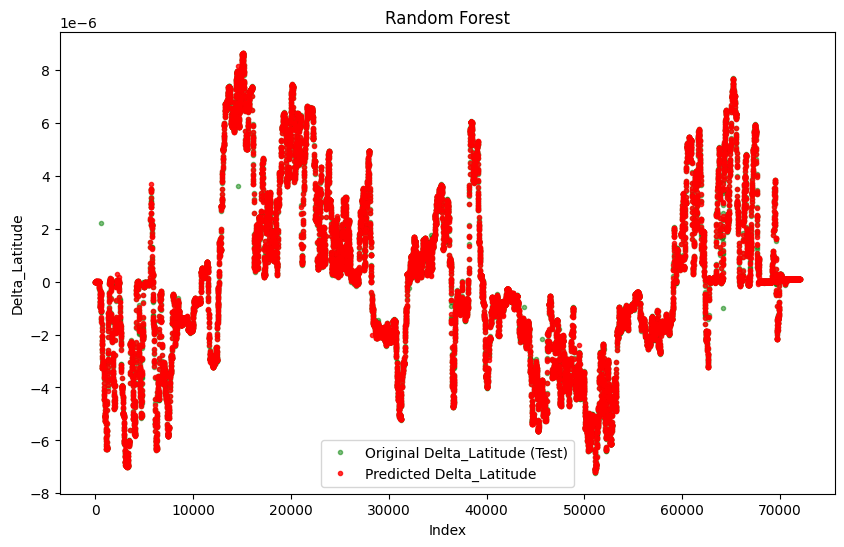

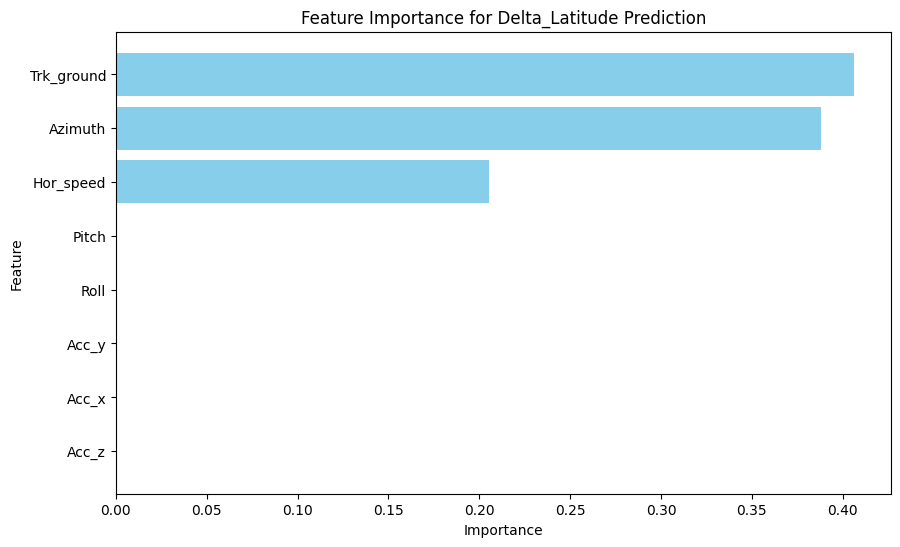

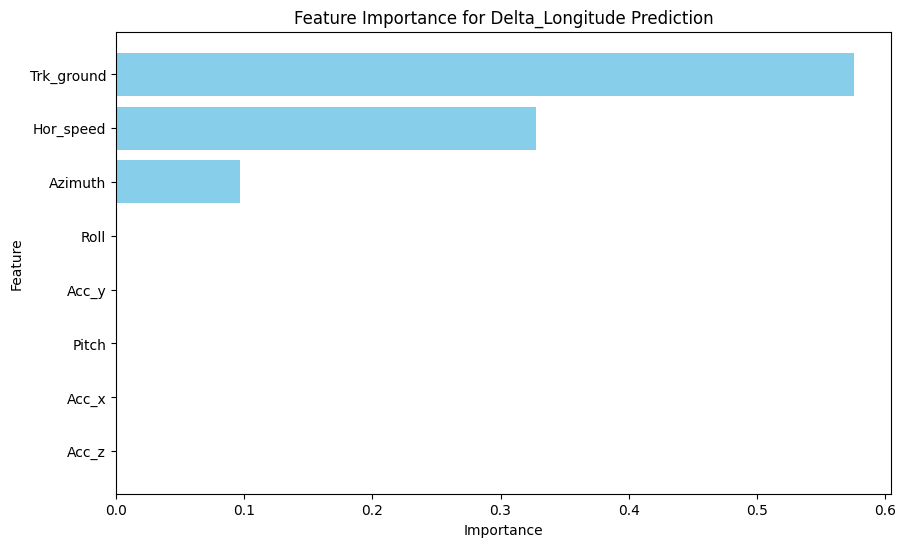

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import joblib

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(X, y_lat, y_lon, test_size=0.2, random_state=42)

# Initialize Random Forest models
model_lat = RandomForestRegressor(n_estimators=100, random_state=42)
model_lon = RandomForestRegressor(n_estimators=100, random_state=42)

# Train Random Forest models
model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)

# Save trained models to pickle files
joblib.dump(model_lat, 'rf_regressor_lat_model.pkl')
joblib.dump(model_lon, 'rf_regressor_lon_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.15f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.15f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.17f}")

lon_mse=mean_squared_error(y_lon_test,y_lon_pred)
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.17f}")


import matplotlib.pyplot as plt

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2,alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1,alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('Random Forest')

# Add legend
plt.legend() 
# Show plot
plt.show()


# Feature importance for Delta_Latitude model
lat_importances = model_lat.feature_importances_
lon_importances = model_lon.feature_importances_

# Create DataFrame for feature importances
feature_importance_df_lat = pd.DataFrame({
    'Feature': features,
    'Importance': lat_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df_lon = pd.DataFrame({
    'Feature': features,
    'Importance': lon_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances for Delta_Latitude
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_lat['Feature'], feature_importance_df_lat['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Delta_Latitude Prediction')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Plot feature importances for Delta_Longitude
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_lon['Feature'], feature_importance_df_lon['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Delta_Longitude Prediction')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

## XG Boosting

Latitude Prediction R^2 Score: -0.000205
Longitude Prediction R^2 Score: -0.000254


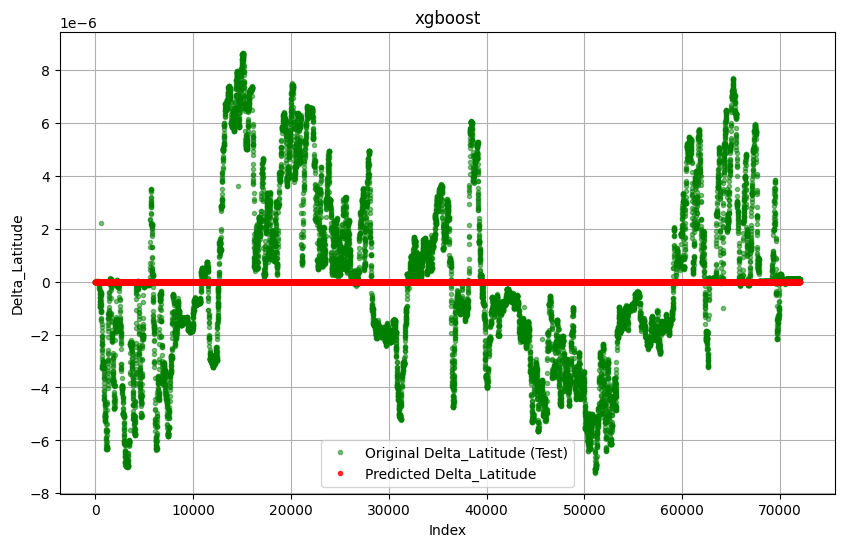

In [13]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib
from matplotlib import pyplot as plt

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost models
model_lat = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_lon = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train XGBoost models
model_lat.fit(X_train_scaled, y_lat_train)
model_lon.fit(X_train_scaled, y_lon_train)

# Save trained models to pickle files
joblib.dump(model_lat, 'xg_boost_lat_model.pkl')
joblib.dump(model_lon, 'xg_boost_lon_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test_scaled)
y_lon_pred = model_lon.predict(X_test_scaled)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.6f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.6f}")

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('xgboost')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()


## light gbm

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 57614, number of used features: 8
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 57614, number of used features: 8
[LightGBM] [Info] Start training from score 0.000000
Latitude Prediction R^2 Score: 0.999395493975824
Longitude Prediction R^2 Score: 0.999522065390506
Mean Squared Error (MSE) for Delta_Latitude: 0.00000000000000632
Mean Squared Error (MSE) for Delta_Longitude: 0.00000000000000694


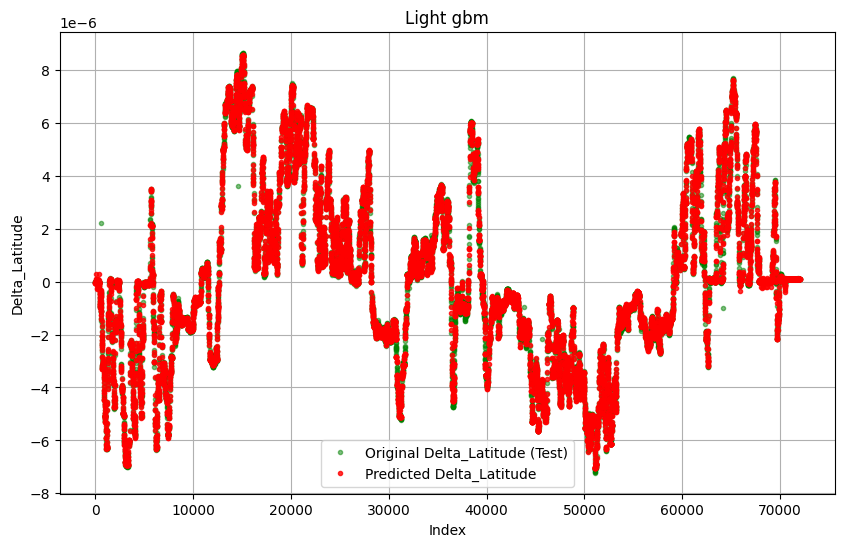

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'


# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Initialize LightGBM models
model_lat = LGBMRegressor(n_estimators=100, random_state=42)
model_lon = LGBMRegressor(n_estimators=100, random_state=42)

# Train LightGBM models
model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)

# Save trained models to pickle files
joblib.dump(model_lat, 'lightgbm_lat_model.pkl')
joblib.dump(model_lon, 'lightgbm_lon_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.15f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.15f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude and Delta_Longitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
lon_mse = mean_squared_error(y_lon_test, y_lon_pred)

print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.17f}")
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.17f}")

# Save the trained models to pickle files
joblib.dump(model_lat, 'lgbm_regressor_lat_model.pkl')
joblib.dump(model_lon, 'lgbm_regressor_lon_model.pkl')

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('Light gbm')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()

## Gradient Boosting

Latitude Prediction R^2 Score: 0.994499653252412
Longitude Prediction R^2 Score: 0.995848359598753
Mean Squared Error (MSE) for Delta_Latitude: 0.00000000000005751
Mean Squared Error (MSE) for Delta_Longitude: 0.00000000000006025


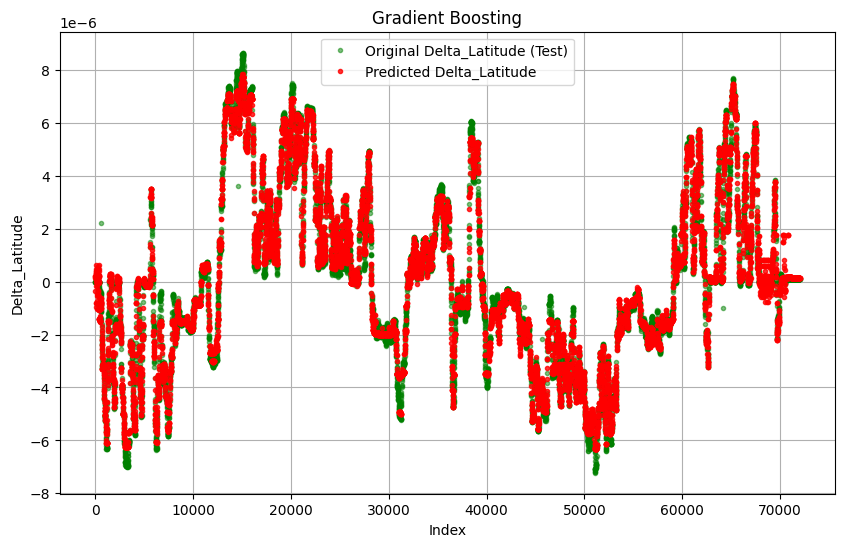

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'


# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Initialize Gradient Boosting models
model_lat = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_lon = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train Gradient Boosting models
model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)

# Save trained models to pickle files
joblib.dump(model_lat, 'gradient-boost_lat_model.pkl')
joblib.dump(model_lon, 'gradient-boost_lon_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.15f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.15f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude and Delta_Longitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
lon_mse = mean_squared_error(y_lon_test, y_lon_pred)

print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.17f}")
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.17f}")

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('Gradient Boosting')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()


## Support vector Machine(SVM)

Latitude Prediction R^2 Score: -0.115438
Longitude Prediction R^2 Score: -0.017730
Mean Squared Error (MSE) for Delta_Latitude: 0.000000
Mean Squared Error (MSE) for Delta_Longitude: 0.000000


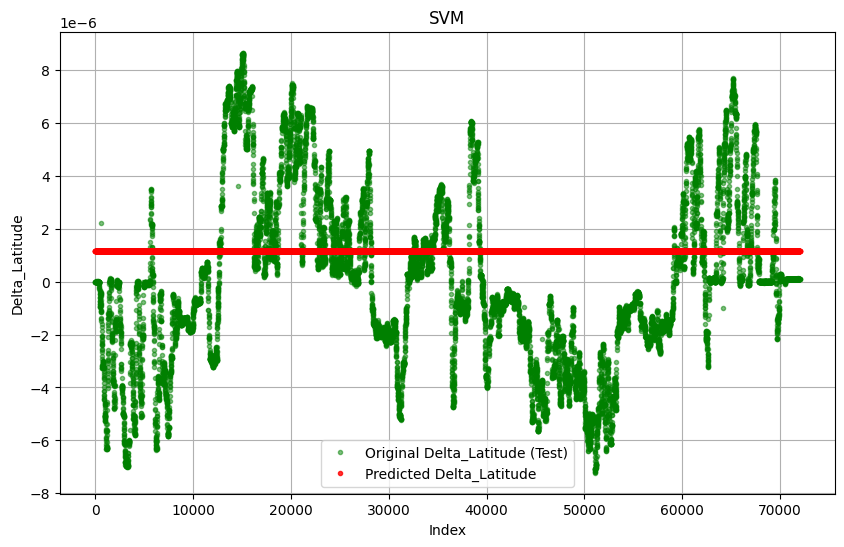

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'


# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Initialize SVR models
model_lat = SVR(kernel='rbf')  # Radial Basis Function (RBF) kernel
model_lon = SVR(kernel='rbf')  # Radial Basis Function (RBF) kernel

# Train SVR models
model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)


# Save trained models to pickle files
joblib.dump(model_lat, 'svm_lat_model.pkl')
joblib.dump(model_lon, 'svm_lon_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.6f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.6f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude and Delta_Longitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
lon_mse = mean_squared_error(y_lon_test, y_lon_pred)

print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.6f}")
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.6f}")

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('SVM')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()


## Catboost

Latitude Prediction R^2 Score: 0.998913262219799
Longitude Prediction R^2 Score: 0.999166019324197
Mean Squared Error (MSE) for Delta_Latitude: 0.00000000000001136
Mean Squared Error (MSE) for Delta_Longitude: 0.00000000000001210


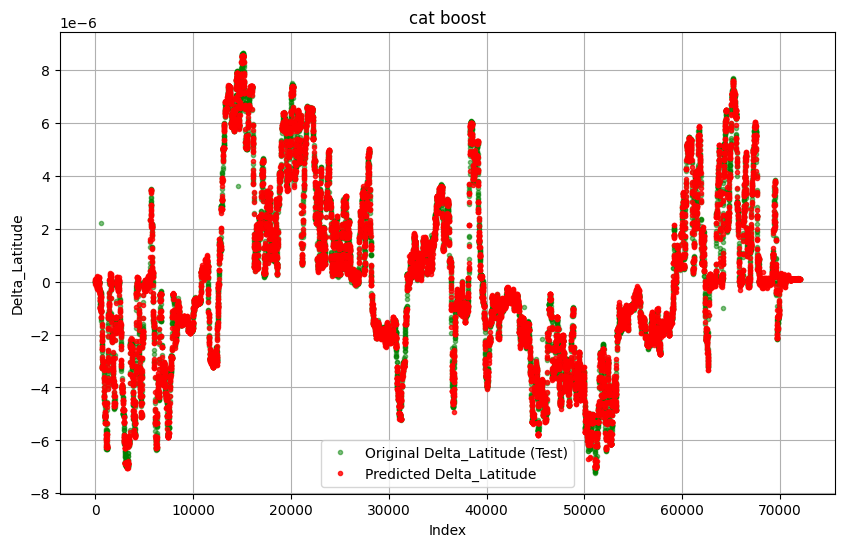

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib
from catboost import CatBoostRegressor

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Initialize CatBoost models
model_lat = CatBoostRegressor(iterations=100, random_seed=42, verbose=0)
model_lon = CatBoostRegressor(iterations=100, random_seed=42, verbose=0)

# Train CatBoost models
model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)

# Save trained models to pickle files
joblib.dump(model_lat, 'catboost_lat_model.pkl')
joblib.dump(model_lon, 'catboost_lon_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.15f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.15f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude and Delta_Longitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
lon_mse = mean_squared_error(y_lon_test, y_lon_pred)

print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.17f}")
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.17f}")

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('cat boost')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()
